In [260]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

from networkx.generators.community import LFR_benchmark_graph


In [449]:
n_small = 250  # 减小节点数量
tau1_small = 3
tau2_small = 1.5
mu_small = 0.03
average_degree_small = 8
min_community_small = 8
max_community_small = 250  # 减小最大社区大小
 # 设置合适的迭代次数
seed=42

In [450]:
G = LFR_benchmark_graph(n_small, tau1_small, tau2_small, mu_small, average_degree_small,
                              min_community=min_community_small, max_community=max_community_small, seed=seed)


In [435]:
G.remove_edges_from(nx.selfloop_edges(G))

In [436]:
# 获取生成的图的基本信息
num_nodes_small = G_small.number_of_nodes()
num_edges_small = G_small.number_of_edges()
communities_small = {frozenset(G_small.nodes[v]['community']) for v in G_small}

# 社区信息
community_sizes_small = [len(c) for c in communities_small]


In [437]:
# 重新构建社区映射
community_id_map = {frozenset(c): idx for idx, c in enumerate(communities_small)}

# 创建节点与其社区的映射字典
node_community_dict = {}
for community in communities_small:
    for node in community:
        node_community_dict[node] = community

# 创建节点与其社区编号的映射字典
partition_infomap = {node: community_id_map[community] for node, community in node_community_dict.items()}


In [438]:
def calculate_mu(G, node_community_dict):
    """
    计算网络的社区混合参数 mu。

    参数:
    G (networkx.Graph): 网络图
    node_community_dict (dict): 节点与社区编号的映射字典

    返回:
    float: 社区混合参数 mu
    """
    internal_edges = 0
    external_edges = 0

    # 遍历图中的每条边
    for u, v in G.edges():
        # 检查这条边是否是社区内部的边
        if node_community_dict[u] == node_community_dict[v]:
            internal_edges += 1
        else:
            external_edges += 1

    # 计算 mu
    total_edges = internal_edges + external_edges
    mu = external_edges / total_edges if total_edges > 0 else 0

    return mu


In [439]:
calculate_mu(G,partition_infomap)

0.9513466550825369

In [366]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores


def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [367]:
degree_centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)


In [368]:
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)



In [369]:
def community_aware_ranking_Baseline(G, partition, node_centrality, budget=None):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    if budget is None:
        budget = len(G)
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [370]:
import networkx as nx
import numpy as np

def community_aware_ranking_ours_v5(G, partition, incommunity, communityImportance, total_budget, alpha=0.1, beta=0.1):
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([communityImportance[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = (size_score ** alpha) * (core_score ** beta)  # 加权计算社区得分

    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []
        nodes_sorted = sorted(community_nodes, key=lambda n: incommunity[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
               
                selected_for_comm.append(node)
                selected_nodes.add(node)
                    
    return selected_nodes


In [371]:
import networkx as nx
import numpy as np

def community_aware_ranking_ours_v6(G, partition, incommunity, total_budget):
    # Step 1: Organize nodes into communities
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    # Step 2: Compute community scores
    community_scores = {}
    for comm_id, nodes in communities.items():
        internal_edges = G.subgraph(nodes).size()  # Number of edges within the community
        size = len(nodes)
        external_connections = 0
        for node in nodes:
            for neighbor in G.neighbors(node):
                if partition[neighbor] != comm_id:
                    external_connections += 1

        # Score calculation based on internal structure and external connections
        community_scores[comm_id] = size * internal_edges + external_connections * size
    
    print(community_scores)
    # Step 3: Rank communities by score
    ranked_communities = sorted(community_scores.items(), key=lambda item: item[1], reverse=True)
    ranked_community_ids = [comm_id for comm_id, _ in ranked_communities]
    
    # Step 4: Allocate budget cyclically, selecting nodes from ranked communities
    selected_nodes = set()
    remaining_budget = total_budget
    # Sort nodes within each community by their importance
    for comm_id in ranked_community_ids:
        communities[comm_id].sort(key=lambda x: incommunity[x], reverse=True)

    # Cycle through communities until budget is exhausted
    index = 0
    while remaining_budget > 0:
        comm_id = ranked_community_ids[index % len(ranked_community_ids)]
        if communities[comm_id]:
            selected_nodes.add(communities[comm_id].pop(0))
            remaining_budget -= 1
        index += 1

    return selected_nodes


In [372]:

budget = 100


ranked_nodes_ours = community_aware_ranking_ours_v5(G, partition_infomap,degree_centrality,kShell, budget)
ranked_nodes_baseline = community_aware_ranking_Baseline(G, partition_infomap, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_ours)
print("Ranked informap Nodes:", ranked_nodes_baseline)


Ranked Nodes: {514, 524, 535, 28, 37, 551, 39, 562, 564, 57, 570, 580, 70, 78, 593, 82, 595, 596, 85, 83, 604, 613, 616, 617, 623, 112, 626, 118, 121, 126, 128, 139, 151, 664, 672, 171, 178, 188, 702, 713, 714, 715, 729, 228, 237, 751, 243, 768, 257, 770, 779, 782, 280, 285, 286, 297, 299, 814, 306, 829, 836, 842, 336, 851, 855, 856, 345, 357, 872, 371, 374, 889, 385, 386, 395, 947, 442, 954, 962, 453, 968, 459, 980, 984, 476, 479, 992, 998}
Ranked informap Nodes: [126, 285, 836, 37, 856, 954, 243, 751, 228, 626, 872, 297, 564, 178, 82, 672, 128, 395, 535, 386, 623, 664, 345, 139, 889, 617, 371, 524, 729, 257, 479, 715, 385, 851, 78, 453, 782, 286, 514, 580, 770, 121, 442, 171, 188, 57, 714, 299, 984, 112, 459, 962, 829, 980, 613, 814, 551, 237, 28, 476, 280, 593, 562, 616, 85, 779, 842, 39, 306, 998, 374, 713, 968, 151, 992, 855, 357, 570, 595, 947, 70, 336, 604, 596, 118, 768, 702, 83, 402, 534, 233, 553, 270, 410, 212, 543, 138, 575, 44, 326]


In [373]:
ranked_nodes_V6 = community_aware_ranking_ours_v6(G, partition_infomap,degree_centrality, budget)

{0: 13392, 1: 105732, 2: 8959, 3: 14700, 4: 41580, 5: 7150, 6: 9120, 7: 4960, 8: 6500, 9: 5543, 10: 38584, 11: 97097, 12: 57232, 13: 43200, 14: 20597, 15: 6526, 16: 14578, 17: 24059, 18: 19688, 19: 4080, 20: 16419, 21: 37510}


In [374]:
print(ranked_nodes_V6)

{514, 524, 17, 534, 535, 28, 543, 37, 551, 39, 553, 44, 562, 564, 57, 570, 575, 580, 70, 78, 593, 82, 595, 596, 85, 83, 604, 613, 616, 617, 623, 112, 626, 118, 121, 126, 128, 138, 139, 151, 664, 672, 171, 178, 188, 702, 713, 714, 715, 212, 729, 228, 233, 237, 751, 243, 768, 257, 770, 779, 782, 270, 280, 285, 286, 297, 299, 814, 306, 829, 836, 842, 336, 851, 855, 856, 345, 357, 872, 371, 374, 889, 385, 386, 395, 402, 410, 947, 954, 442, 962, 453, 968, 459, 980, 984, 476, 479, 992, 998}


0.9427782888684453

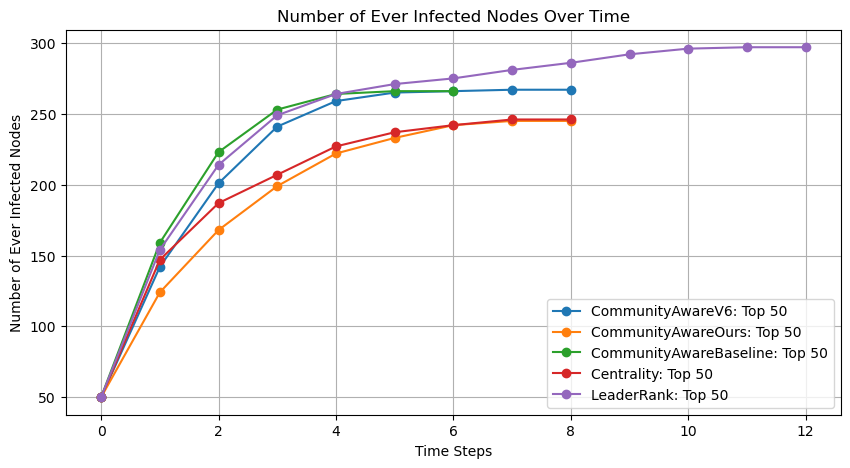

In [293]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    #avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
   # print(avg_in_degree)
    #recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 1, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    "CommunityAwareV6": [(node, degree_centrality[node]) for node in ranked_nodes_V6],
    "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_baseline],
    "Centrality": sorted_centrality,
    #"indegree_centrality": sorted_indegree_centrality,
    #"PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
   # "H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=50, infection_prob=0.08,steps=20)

In [294]:


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

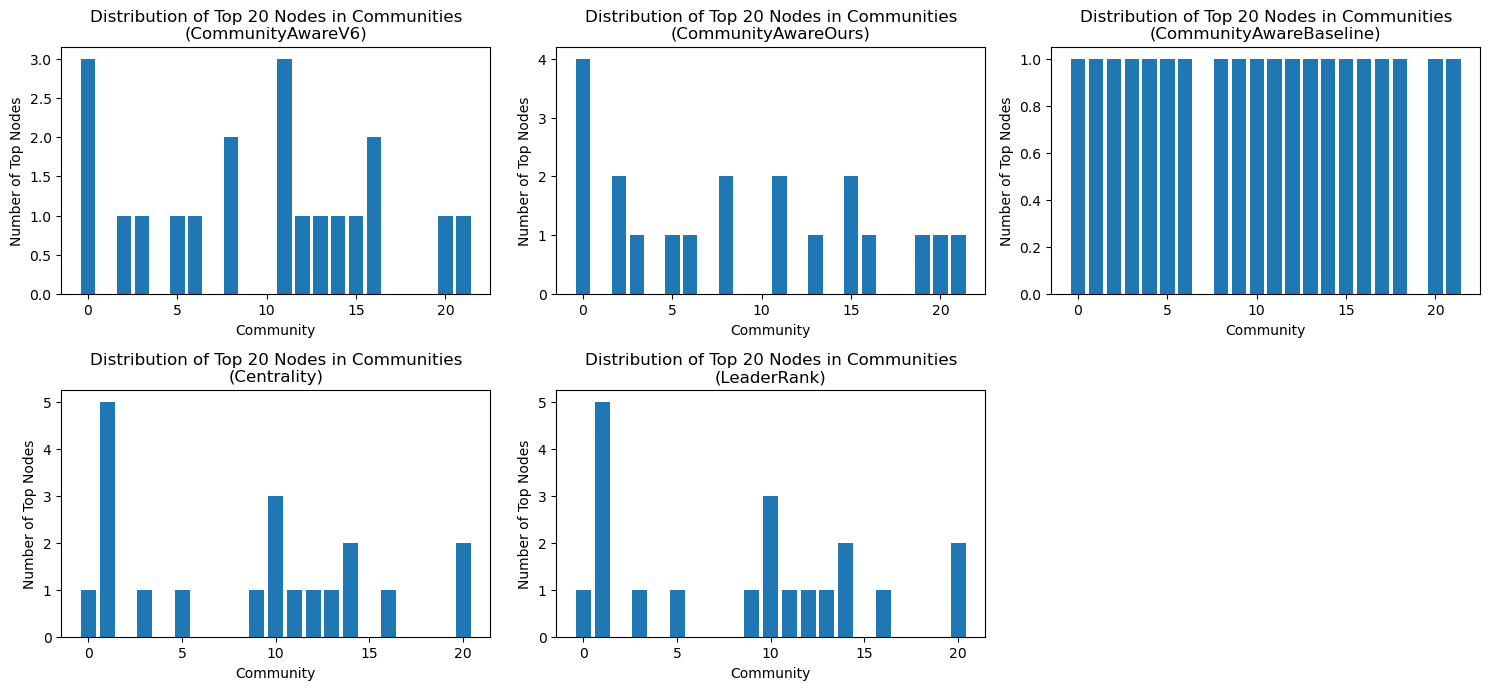

In [295]:

top = 20

community_counts = count_top_nodes_in_communities(G, sorted_maps, top, partition_infomap)
plot_top_nodes_distribution(community_counts, top)

In [255]:

sorted_community_counts = count_and_sort_communities(partition_infomap)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 1: 99 nodes
Community 11: 97 nodes
Community 12: 73 nodes
Community 13: 64 nodes
Community 4: 63 nodes
Community 21: 62 nodes
Community 10: 56 nodes
Community 17: 49 nodes
Community 18: 46 nodes
Community 14: 43 nodes
Community 20: 39 nodes
Community 16: 37 nodes
Community 0: 36 nodes
Community 3: 35 nodes
Community 2: 31 nodes
Community 6: 30 nodes
Community 5: 26 nodes
Community 15: 26 nodes
Community 8: 25 nodes
Community 9: 23 nodes
Community 7: 20 nodes
Community 19: 20 nodes


In [256]:
def calculate_community_kshell_stats(partition, kshell_scores):
    """
    计算每个社区的k-shell值的均值和总值。

    参数:
    partition: 字典，节点到社区ID的映射。
    kshell_scores: 字典，节点的k-shell得分。

    返回:
    community_stats: 字典，每个社区的k-shell均值和总和。
    """
    # 组织每个社区的节点
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    # 计算每个社区的k-shell均值和总和
    community_stats = {}
    for comm_id, nodes in communities.items():
        kshell_values = [kshell_scores[node] for node in nodes]
        mean_kshell = sum(kshell_values) / len(kshell_values) if kshell_values else 0
        total_kshell = sum(kshell_values)
        community_stats[comm_id] = {'mean': mean_kshell, 'total': total_kshell}

    return community_stats

community_stats = calculate_community_kshell_stats(partition_infomap, kShell)

# 打印每个社区的统计数据
for comm_id, stats in community_stats.items():
    print(f"社区 {comm_id} - 均值: {stats['mean']}, 总和: {stats['total']}")


社区 0 - 均值: 6.666666666666667, 总和: 240
社区 1 - 均值: 6.494949494949495, 总和: 643
社区 2 - 均值: 6.354838709677419, 总和: 197
社区 3 - 均值: 6.685714285714286, 总和: 234
社区 4 - 均值: 6.507936507936508, 总和: 410
社区 5 - 均值: 6.5, 总和: 169
社区 6 - 均值: 6.8, 总和: 204
社区 7 - 均值: 6.65, 总和: 133
社区 8 - 均值: 6.6, 总和: 165
社区 9 - 均值: 6.304347826086956, 总和: 145
社区 10 - 均值: 6.714285714285714, 总和: 376
社区 11 - 均值: 6.628865979381444, 总和: 643
社区 12 - 均值: 6.876712328767123, 总和: 502
社区 13 - 均值: 6.578125, 总和: 421
社区 14 - 均值: 6.651162790697675, 总和: 286
社区 15 - 均值: 6.269230769230769, 总和: 163
社区 16 - 均值: 6.486486486486487, 总和: 240
社区 17 - 均值: 6.489795918367347, 总和: 318
社区 18 - 均值: 6.565217391304348, 总和: 302
社区 19 - 均值: 6.6, 总和: 132
社区 20 - 均值: 6.538461538461538, 总和: 255
社区 21 - 均值: 6.483870967741935, 总和: 402


In [296]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10):
    # 检查 selected_nodes 的数量不小于 top_n
   

    # 选择 top_n 个节点进行突出显示
    # 确保 selected_nodes 列表中只有节点标识符
    top_selected_nodes = [node[0] for node in selected_nodes[:top_n]]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=top_selected_nodes, node_color='red', node_size=100)
    # 可选：添加节点的标签
    # nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in top_selected_nodes})

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 使用示例
# 假设 G 是你的图对象，selected_nodes 是已按度中心性排序的节点列表（列表元素为(node, centrality)格式）
# visualize_selected_nodes_with_highlight(G, selected_nodes, top_n=10)


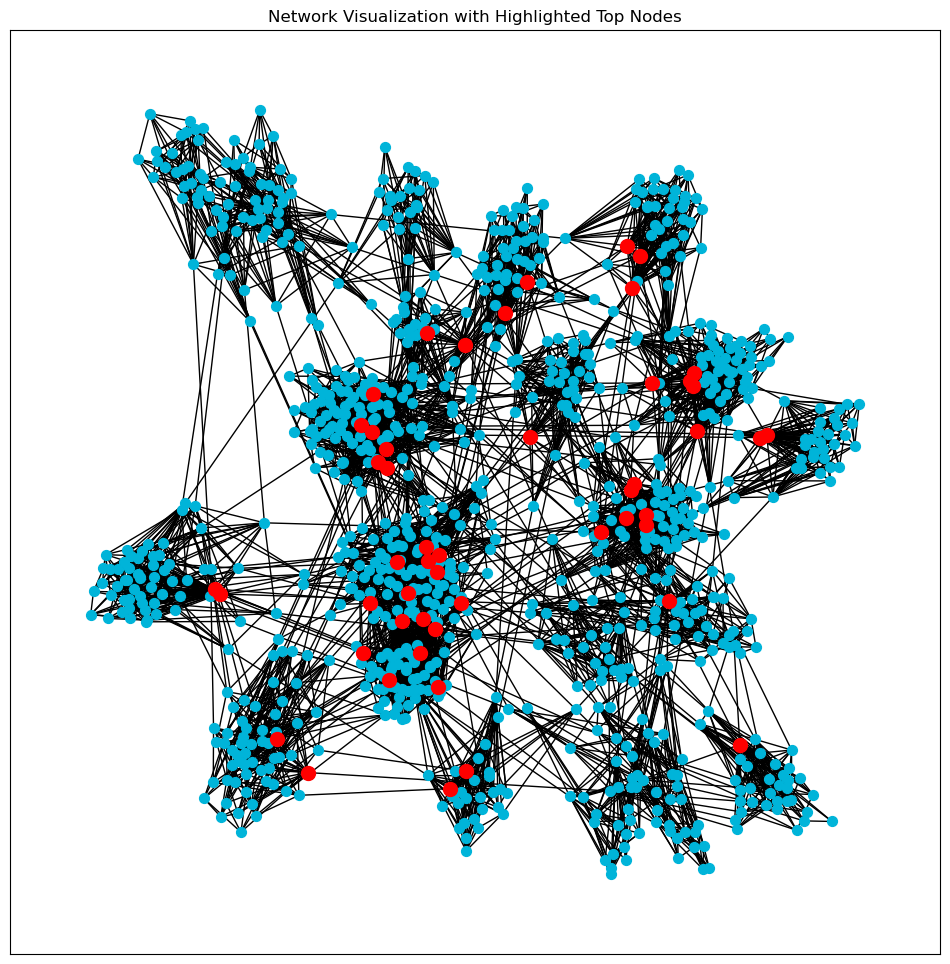

In [297]:
visualize_selected_nodes_with_highlight(G, sorted_centrality, top_n=50)

In [259]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_selected_nodes_to_Selected(G, selected_nodes, top):
    # 计算网络中节点的数量
    network_size = len(G.nodes())

    # 设置低位数比例为网络大小的 15%
    low_fraction = top
    

    # 确保 selected_nodes 是列表，以便进行索引和切片操作
    selected_nodes = list(selected_nodes)[:low_fraction] if isinstance(selected_nodes, set) else selected_nodes[:low_fraction]

    # 计算布局
    pos = nx.spring_layout(G, seed=42)  # 使用固定的种子以便每次布局相同

    # 手动绘制图形
    plt.figure(figsize=(12, 12))
    # 绘制所有节点
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#00b4d9')
    # 绘制所有边
    nx.draw_networkx_edges(G, pos)
    # 特别突出显示 top_selected_nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='red', node_size=100)
    # 添加标签（可选）
    # nx.draw_networkx_labels(G, pos)

    # 添加标题
    plt.title("Network Visualization with Highlighted Top Nodes")
    # 显示图
    plt.show()

# 假设 G 是你的图对象，partition 是社区划分，selected_nodes 是选出的节点列表（已排序）
# visualize_selected_nodes_with_highlight(G, partition, selected_nodes)


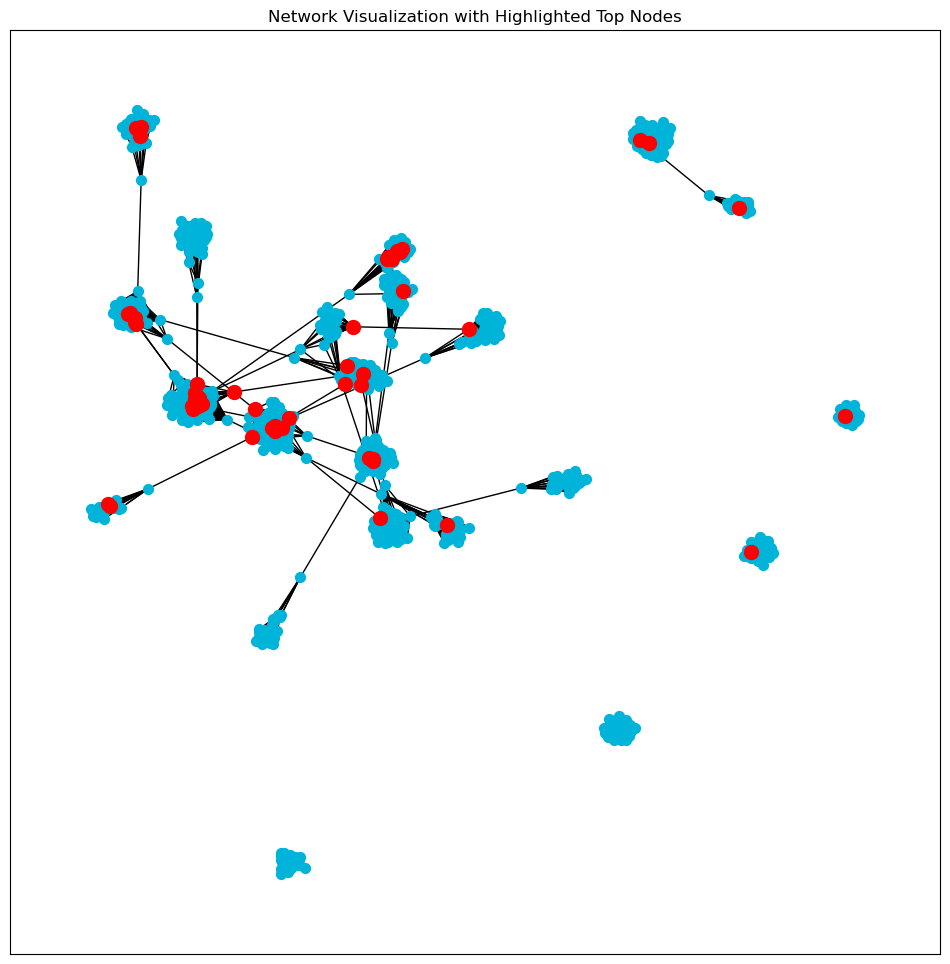

In [193]:
visualize_selected_nodes_to_Selected(G, ranked_nodes_V6,50)